# Movie Recommender System

## Introduction

In today's digital age, users are inundated with a vast array of movie options, making it challenging to find content that aligns with their preferences. To enhance the user experience, this project develops a **Movie Recommender System** that provides personalized movie recommendations based on user ratings and the ratings of similar users. This system leverages collaborative filtering techniques, including both user-based and item-based approaches, to identify and recommend movies that users are likely to enjoy.

The dataset utilized for this project comprises user ratings, user demographics, and movie information. The objective is to transform this raw data into a consolidated format suitable for analysis, perform exploratory data analysis (EDA), and implement various recommendation algorithms. The effectiveness of these algorithms will be evaluated using metrics such as Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE), ensuring that the recommendations are both relevant and reliable. By the end of this project, a robust and user-friendly recommender system will be delivered, enhancing movie discovery for users.


In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from cmfrec import CMF
from sklearn.metrics.pairwise import cosine_similarity

# Data Loading

This section of the code loads the movie, ratings, and user datasets into Pandas DataFrames using the fixed-width format. The datasets are read from the specified files with the appropriate encoding to ensure proper handling of any special characters.


In [2]:
movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [3]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [4]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [5]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [6]:
movies.shape,ratings.shape,users.shape

((3883, 3), (1000209, 1), (6040, 1))

In [7]:
movies.columns

Index(['Movie ID::Title::Genres', 'Unnamed: 1', 'Unnamed: 2'], dtype='object')

In [8]:
movies['Unnamed: 1'].isna().sum(),movies['Unnamed: 2'].isna().sum()

(3783, 3832)

# Data Cleaning and Transformation

This section cleans and transforms the movie dataset. It removes unnecessary columns, splits the combined movie information into separate columns (`movie_id`, `title`, and `genres`), and displays the first few rows of the cleaned DataFrame.


In [9]:
movies.drop(['Unnamed: 1','Unnamed: 2'],axis=1,inplace=True)
movies[['movie_id', 'title', 'genres']] = movies['Movie ID::Title::Genres'].str.split('::', expand=True)
movies.drop('Movie ID::Title::Genres',axis=1,inplace=True)
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Genre Standardization

This section standardizes the genres in the movie dataset by mapping various genre abbreviations and variations to a consistent format. The `genres` column is updated with standardized genre names, ensuring uniformity for analysis and recommendations. The first few rows of the cleaned DataFrame are displayed to verify the changes.


In [10]:
movies['genres'] = movies['genres'].str.split('|')
ls = []
for i in movies['genres']:
    if i is not None:
        for j in i:
            ls.append(j)
unique_genres = set(ls)
unique_genres

{'',
 'A',
 'Acti',
 'Action',
 'Adv',
 'Advent',
 'Adventu',
 'Adventur',
 'Adventure',
 'Animati',
 'Animation',
 'Chi',
 'Chil',
 'Childr',
 'Childre',
 'Children',
 "Children'",
 "Children's",
 'Com',
 'Come',
 'Comed',
 'Comedy',
 'Crime',
 'D',
 'Docu',
 'Documen',
 'Document',
 'Documenta',
 'Documentary',
 'Dr',
 'Dram',
 'Drama',
 'F',
 'Fant',
 'Fantas',
 'Fantasy',
 'Film-Noir',
 'Horr',
 'Horro',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'R',
 'Ro',
 'Rom',
 'Roma',
 'Roman',
 'Romance',
 'S',
 'Sci',
 'Sci-',
 'Sci-F',
 'Sci-Fi',
 'Th',
 'Thri',
 'Thrille',
 'Thriller',
 'Wa',
 'War',
 'We',
 'Wester',
 'Western'}

In [11]:
genre_mapping = {
    'A': 'Action',
    'Acti': 'Action',
    'Action': 'Action',
    'Adv': 'Adventure',
    'Advent': 'Adventure',
    'Adventu': 'Adventure',
    'Adventur': 'Adventure',
    'Adventure': 'Adventure',
    'Animati': 'Animation',
    'Animation': 'Animation',
    'Chi': "Children's",
    'Chil': "Children's",
    'Childr': "Children's",
    'Childre': "Children's",
    'Children': "Children's",
    "Children'": "Children's",
    "Children's": "Children's",
    'Com': 'Comedy',
    'Come': 'Comedy',
    'Comed': 'Comedy',
    'Comedy': 'Comedy',
    'Crime': 'Crime',
    'D': 'Documentary',
    'Docu': 'Documentary',
    'Documen': 'Documentary',
    'Document': 'Documentary',
    'Documenta': 'Documentary',
    'Documentary': 'Documentary',
    'Dr': 'Drama',
    'Dram': 'Drama',
    'Drama': 'Drama',
    'F': 'Fantasy',
    'Fant': 'Fantasy',
    'Fantas': 'Fantasy',
    'Fantasy': 'Fantasy',
    'Film-Noir': 'Film-Noir',
    'Horr': 'Horror',
    'Horro': 'Horror',
    'Horror': 'Horror',
    'Music': 'Musical',
    'Musical': 'Musical',
    'Mystery': 'Mystery',
    'R': 'Romance',
    'Ro': 'Romance',
    'Rom': 'Romance',
    'Roma': 'Romance',
    'Roman': 'Romance',
    'Romance': 'Romance',
    'S': 'Science Fiction',
    'Sci': 'Science Fiction',
    'Sci-': 'Science Fiction',
    'Sci-F': 'Science Fiction',
    'Sci-Fi': 'Science Fiction',
    'Th': 'Thriller',
    'Thri': 'Thriller',
    'Thrille': 'Thriller',
    'Thriller': 'Thriller',
    'Wa': 'War',
    'War': 'War',
    'We': 'Western',
    'Wester': 'Western',
    'Western': 'Western',
    'Fi': 'Fiction'  # Added Fiction mapping
}
for i in movies['genres']:
    if i is not None:
        for j in i:
            if j in genre_mapping:
                i[:] = [genre_mapping[j] if x == j else x for x in i]
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),[Comedy]


# List of Unique Genres

The following unique genres have been identified from the movie dataset after standardization:


In [12]:
ls = []
for i in movies['genres']:
    if i is not None:
        for j in i:
            ls.append(j)
unique_genres = set(ls)
unique_genres

{'',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

# Genre One-Hot Encoding and Grouping

One-hot encoding is performed on the exploded genres of the movie dataset. The genres are converted into dummy variables, which are then summed for each movie. The resulting DataFrame is grouped by `movie_id` and `title`, and the genres are represented as binary indicators. The final DataFrame structure is displayed to confirm the transformations and ensure readiness for analysis.


In [13]:
movies_exploded = movies.explode('genres')
genre_dummies = pd.get_dummies(movies_exploded['genres'])
genre_dummies.head(3)

,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Science Fiction,Thriller,War,Western
0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
movies_grouped = movies_exploded[['movie_id', 'title']].join(genre_dummies).groupby(['movie_id', 'title']).sum().reset_index()
movies_grouped.head(3)

,movie_id,title,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Science Fiction,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,3,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,GoldenEye (1995),0,3,3,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
2,100,City Hall (1996),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [15]:
genre_columns = movies_grouped.columns[2:]
movies_grouped[genre_columns] = (movies_grouped[genre_columns] >= 1).astype(int)
movies_grouped.drop('',inplace=True,axis=1)
movies_grouped['movie_id'] = movies_grouped['movie_id'].astype(int)
movies_grouped['title']= movies_grouped['title'].astype(str)
movies_grouped.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Science Fiction,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10,GoldenEye (1995),1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,100,City Hall (1996),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1000,Curdled (1996),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1001,"Associate, The (L'Associe)(1982)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
movies_grouped.columns,movies_grouped.shape

(Index(['movie_id', 'title', 'Action', 'Adventure', 'Animation', 'Children's',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
        'Horror', 'Musical', 'Mystery', 'Romance', 'Science Fiction',
        'Thriller', 'War', 'Western'],
       dtype='object'),
 (3883, 20))

# Visualization of Top 5 Genres

Total counts for each genre are calculated, and the top 5 genres in the dataset are identified. A bar chart is created to visualize the counts of these genres, providing insights into the most popular genres among the movies.


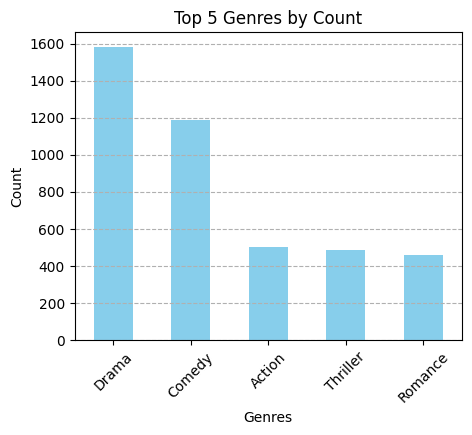

In [17]:
genre_columns = movies_grouped.columns[2:]
# Sum counts for each genre
genre_counts = movies_grouped[genre_columns].sum().sort_values(ascending=False)

# top 5 genres
top_5_genres = genre_counts.head(5)

plt.figure(figsize=(5,4))
top_5_genres.plot(kind='bar', color='skyblue')
plt.title('Top 5 Genres by Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

# Formatting Ratings Data

The ratings dataset is formatted by splitting the `UserID::MovieID::Rating::Timestamp` column into separate columns for `user_id`, `movie_id`, and `rating`. The `timestamp` column is then dropped, resulting in a cleaner DataFrame that displays the first few rows for verification.


In [18]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [19]:
ratings[['user_id','movie_id','rating','timestamp']] = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::', expand=True)
ratings.drop(['UserID::MovieID::Rating::Timestamp','timestamp'],axis=1,inplace=True)
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [20]:
ratings['user_id'] = ratings['user_id'].astype(int)
ratings['movie_id'] = ratings['movie_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)
ratings.head(3)

,user_id,movie_id,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0


# Formatting Users Data

The users dataset is formatted by splitting the `UserID::Gender::Age::Occupation::Zip-code` column into separate columns for `user_id`, `gender`, `age`, `occupation`, and `zip-code`. The `occupation` and `zip-code` columns are dropped, and the `gender` column is transformed into a binary format (0 for male, 1 for female). The `age` column is also converted to integer type for further analysis.


In [21]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


In [22]:
users[['user_id','gender','age','occupation','zip-code']] = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::', expand=True)
users.drop(['UserID::Gender::Age::Occupation::Zip-code','occupation','zip-code'],axis=1,inplace=True)
users['gender'] = users['gender'].apply(lambda x: 0 if x == 'M' else 1)
users['age']= users['age'].astype(int)

In [23]:
users['user_id'] = users['user_id'].astype(float)
users['gender'] = users['gender'].astype(float)
users.head()

,user_id,gender,age
0,1.0,1.0,1
1,2.0,0.0,56
2,3.0,0.0,25
3,4.0,0.0,45
4,5.0,0.0,25


# Merging Datasets

The ratings dataset is merged with the users dataset based on the `user_id`, followed by merging the resulting DataFrame with the grouped movies dataset based on the `movie_id`.


In [24]:
merged_df = pd.merge(ratings, users, on='user_id')
movies_df = pd.merge(merged_df, movies_grouped, on='movie_id')
movies_df.head(3)

,user_id,movie_id,rating,gender,age,title,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Science Fiction,Thriller,War,Western
0,1,1193,5.0,1.0,1,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3.0,1.0,1,James and the Giant Peach (1996),0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3.0,1.0,1,My Fair Lady (1964),0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


# Visualization of Top 5 Movies Based on Average Ratings

The average ratings for each movie are calculated and sorted to identify the top 5 movies.

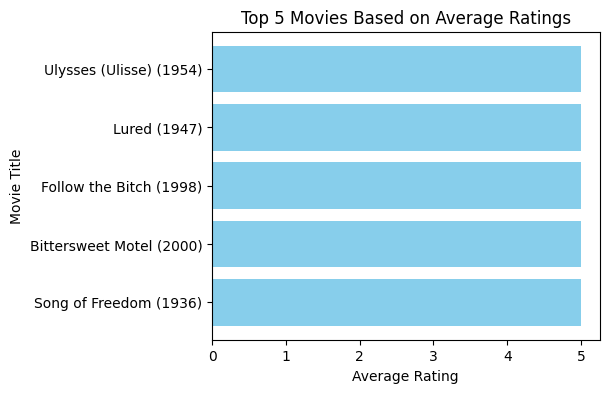

In [25]:
top_5_movies = movies_df.groupby('title')['rating'].mean().reset_index()
top_5_movies = top_5_movies.sort_values(by='rating', ascending=False).head(5)

plt.figure(figsize=(5,4))
plt.barh(top_5_movies['title'], top_5_movies['rating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 5 Movies Based on Average Ratings')
plt.gca().invert_yaxis()
plt.show()

# Visualization of Top 5 Animation Movies Based on Average Ratings

 The top 5 animation movies are identified and visualized using a horizontal bar chart, showcasing their average ratings for comparison.


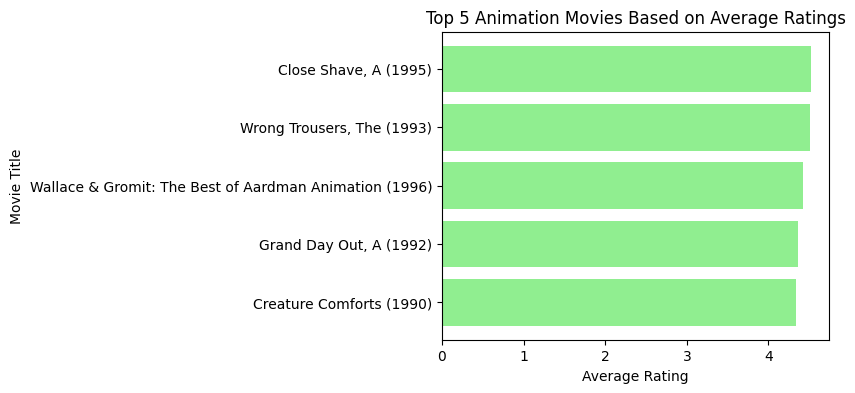

In [26]:
animation_movies = movies_df[movies_df['Animation'] == 1]
top_animation_movies = animation_movies.groupby('title')['rating'].mean().reset_index()
top_animation_movies = top_animation_movies.sort_values(by='rating', ascending=False).head(5)

plt.figure(figsize=(5,4))
plt.barh(top_animation_movies['title'], top_animation_movies['rating'], color='lightgreen')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 5 Animation Movies Based on Average Ratings')
plt.gca().invert_yaxis()
plt.show()

# Creation of User-Movie Rating Matrix

A user-movie rating matrix is constructed by pivoting the ratings DataFrame. This matrix uses `user_id` as the index and `movie_id` as the columns, filling in missing values with zero. The first three rows of the matrix are displayed to provide an overview of the structure.


In [27]:
user_movie_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
user_movie_matrix.head(3)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
ratings.columns

Index(['user_id', 'movie_id', 'rating'], dtype='object')

# Collaborative Filtering Using Matrix Factorization

This section initializes a Collaborative Matrix Factorization (CMF) model utilizing the Alternating Least Squares (ALS) method. The model is fitted with the ratings data, and a predicted user-item rating matrix is generated. Missing values in the original user-movie matrix are then filled with the predicted ratings to create a more complete matrix, which is displayed for review.


In [29]:
rm_raw = ratings[['user_id', 'movie_id', 'rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
rm_raw.head(2)

,UserId,ItemId,Rating
0,1,1193,5.0
1,1,661,3.0


In [30]:
rm_raw.shape

(1000209, 3)

In [31]:
!pip install cmfrec

In [34]:
# Initializing the CMF model with ALS method, rank (k), and regularization parameter (lambda_)
model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
# Fit model with the ratings data
model.fit(rm_raw)

predicted_matrix = model.A_ @ model.B_.T

user_movie_array = user_movie_matrix.values

user_movie_array[user_movie_array == 0] = predicted_matrix[user_movie_array == 0]

filled_user_movie_matrix = pd.DataFrame(user_movie_array, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
filled_user_movie_matrix.head(3)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.000000,0.336853,0.763873,0.581200,0.557788,0.547927,0.688747,0.552170,0.725010,0.757299,...,0.377200,-0.207252,0.052893,0.099589,0.087532,0.076345,-0.128207,0.100165,0.175297,0.011974
2,0.614668,-0.706244,1.117011,0.733387,0.453409,0.795853,1.055105,0.713395,0.755004,1.143605,...,-0.073921,0.040615,-0.239206,-0.143517,0.070375,0.104042,-0.230198,0.034948,0.806149,-0.004079
3,0.433845,-0.699437,-0.065911,0.307546,0.118589,0.682133,0.508015,0.483780,-0.533589,-0.012076,...,-0.595205,0.327034,-0.081128,-0.270046,-0.140035,0.069214,-0.140079,-1.349344,0.458024,0.041667


# Movie Similarity Calculation Using Pearson Correlation

This section computes the similarity between movies based on the filled user-movie rating matrix using Pearson correlation. The resulting similarity matrix provides insights into how closely related different movies are, based on user ratings.


In [35]:
movie_similarity = filled_user_movie_matrix.corr(method='pearson')
movie_similarity.head(3)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.296380,0.202143,0.177616,0.247490,0.228936,0.246328,0.257781,0.132577,0.265805,...,0.113787,-0.115560,0.117801,0.042904,0.031349,0.148999,0.058920,0.018566,-0.003797,0.071646
2,0.296380,1.000000,0.228444,0.188592,0.305583,0.177988,0.219709,0.304499,0.250816,0.327715,...,0.251964,-0.301261,0.274324,0.185738,0.112951,0.127902,0.072937,0.116109,-0.128567,0.076716
3,0.202143,0.228444,1.000000,0.496062,0.484989,0.137525,0.484624,0.370858,0.580853,0.392336,...,0.368335,-0.479178,-0.008009,0.234096,0.193712,0.073469,-0.035182,0.354585,0.250714,0.042001


# Item-Based Movie Recommendation system

This function, `recommend_top_5_movies_by_title`, generates movie recommendations based on a specified movie title. By utilizing a similarity matrix, it identifies and returns the top five movies that are most similar to the input title, enhancing user experience through tailored movie suggestions.


In [61]:
def recommend_top_5_movies_by_title(movie_title, movie_similarity, movies_df):
    if movie_title in movies_df['title'].values:
        movie_id = movies_df[movies_df['title'] == movie_title]['movie_id'].values[0]
    else:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return pd.DataFrame()

    if movie_id not in movie_similarity.columns:
        print(f"Movie ID {movie_id} not found in similarity matrix.")
        return pd.DataFrame()

    similarity_scores = movie_similarity[movie_id]
    similar_movies = similarity_scores.sort_values(ascending=False).drop(movie_id)
    top_similar_movie_ids = similar_movies.head(5).index
    recommended_movies = movies_df[movies_df['movie_id'].isin(top_similar_movie_ids)][['movie_id', 'title']]
    return recommended_movies.reset_index(drop=True)


movie_title = "Beauty and the Beast (1991)"
recommended_movies_df = recommend_top_5_movies_by_title(movie_title, movie_similarity, movies_df)
recommended_movies_df.head(5)

,movie_id,title
0,2018,Bambi (1942)
1,1566,Hercules (1997)
2,588,Aladdin (1992)
3,364,"Lion King, The (1994)"
4,588,Aladdin (1992)


In [62]:
movie_title = "Fargo (1996)"
recommended_movies_df = recommend_top_5_movies_by_title(movie_title, movie_similarity, movies_df)
recommended_movies_df.head(5)

,movie_id,title
0,1213,GoodFellas (1990)
1,593,"Silence of the Lambs, The (1991)"
2,593,"Silence of the Lambs, The (1991)"
3,296,Pulp Fiction (1994)
4,50,"Usual Suspects, The (1995)"


# User-User Similarity Matrix

This section computes the user-user similarity matrix using the cosine similarity method based on the filled user-movie ratings matrix. The resulting matrix provides insights into user preferences and can be utilized for collaborative filtering recommendations.


In [67]:
user_similarity = cosine_similarity(filled_user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

print("User-User Similarity Matrix:")
user_similarity_df.head()

User-User Similarity Matrix:


user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.038982,-0.115805,-0.068361,-0.229290,0.129423,0.376608,0.215178,-0.029482,0.479753,...,-0.117677,-0.049607,0.029171,-0.231827,-0.051408,0.233172,0.029103,-0.020546,0.088187,-0.043087
2,0.038982,1.000000,0.480290,0.584722,0.296578,0.449377,0.300681,0.246243,0.486363,0.058194,...,0.392733,0.382859,0.638756,0.143416,0.478931,0.098343,0.399779,0.596293,0.400042,0.360149
3,-0.115805,0.480290,1.000000,0.426420,0.292556,0.269436,0.279169,0.238597,0.563186,-0.071908,...,0.519888,0.294471,0.527228,0.171712,0.454510,-0.016084,0.294391,0.378678,0.366416,0.266118
4,-0.068361,0.584722,0.426420,1.000000,0.612957,0.231583,0.281824,0.342807,0.628921,-0.121085,...,0.047966,0.769872,0.506705,0.678746,0.661069,0.150194,0.497294,0.809971,0.557837,0.583353
5,-0.229290,0.296578,0.292556,0.612957,1.000000,0.000276,0.081054,0.283419,0.544644,-0.216259,...,-0.026987,0.533582,0.191662,0.642277,0.505965,0.189685,0.375303,0.445168,0.317294,0.506599


# User-Based Recommendation System

This section implements a user-based recommendation system that identifies unseen movies for a specific user based on the viewing habits of similar users. By analyzing the preferences of like-minded individuals, it recommends movies that the target user has not yet watched.


In [111]:
def get_unseen_movies(user_id, user_similarity_df, movies_df, num_similar_users=5):

    seen_movies = set(movies_df[movies_df['user_id'] == user_id]['title'].unique())
    others_seen_movies_list = []

    def similar_id(user_id, user_similarity_df, num_similar_users=5):
        cosine_similarity = user_similarity_df.loc[user_id]
        similar_users = cosine_similarity.sort_values(ascending=False)[1:num_similar_users+1]
        return similar_users.index

    for similar_user_id in similar_id(user_id, user_similarity_df, num_similar_users):
        others_seen_movies = set(movies_df[movies_df['user_id'] == similar_user_id]['title'].unique())
        others_seen_movies_list.append(others_seen_movies)

    all_others_seen_movies = set.union(*others_seen_movies_list)
    unseen_movies = all_others_seen_movies - seen_movies
    unseen_movies_df = pd.DataFrame(unseen_movies, columns=['Unseen Movies'])
    return unseen_movies_df

In [113]:
user_id = 1
unseen_movies_df = get_unseen_movies(user_id, user_similarity_df, movies_df)
print("User-User based recommedation:")
unseen_movies_df.head(5)

User-User based recommedation:


,Unseen Movies
0,Fast Times at Ridgemont High (1982)
1,101 Dalmatians (1961)
2,Boys (1996)
3,"Few Good Men, A (1992)"
4,Three Seasons (1999)


# Conclusion

The movie recommendation system developed in this project effectively utilizes both item-based and user-based collaborative filtering techniques. By analyzing user ratings and movie genres, the system is capable of generating personalized recommendations tailored to individual preferences. The item-based approach focuses on the similarity between movies, suggesting alternatives that share common attributes, while the user-based method leverages the collective tastes of similar users to identify unseen films.

The system demonstrates its utility by providing relevant recommendations, enhancing the user experience for movie enthusiasts. Future improvements could include integrating more advanced algorithms, such as matrix factorization or deep learning techniques, and expanding the dataset to encompass a wider range of films and user demographics. Overall, this project showcases the potential of collaborative filtering in delivering tailored content to users.
